# Extract bubble from simulations

In [1]:
import numpy as np
import scipy as scp
from scipy import optimize
import matplotlib.pyplot as plt

### Simulation Parameters 

In [2]:
nLat = 4096
nSims = 100
minSim = 50

nu = 2.*10**(-3)
lamb = 6; print('lamb = ', lamb)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 2 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi0 = 2. * np.pi / 7.; print('phi0 = ', phi0)

alpha = 8.
nCols = 4
phi_initial = np.pi
dt_phi_initial = 0.

############################################################
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha
light_cone = dtout/dx

lamb =  6
m2eff =  0.28
lenLat =  1581.1388300841897
phi0 =  0.8975979010256552


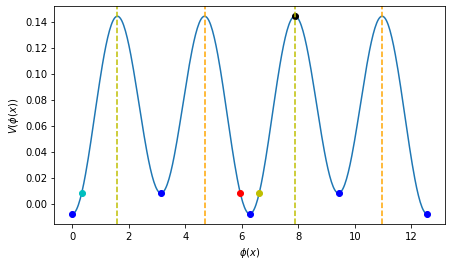

In [3]:
def V(phi):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
def dV(phi):
    return ( np.sin(phi) + 0.5 * lamb**2 * np.sin(2*phi) ) * 4 * nu

right_phi_at_V_max = optimize.minimize`_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = optimize.minimize_scalar(lambda x: -V(x), bounds=[0, np.pi], method='bounded')
right_left_phi_at_V_max = optimize.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded')

def F(x):
    return V(x) - V(phi_initial)
phi_upper_bound = optimize.fsolve(F, 6)[0]
phi_lower_bound = optimize.fsolve(F, 0.5)[0]
phi_upper_lower_bound = optimize.fsolve(F, 7)[0]

fig = plt.figure(figsize=(7, 4))
plt.plot([i for i in np.arange(0, 4*phi_initial, phi_initial/100)], [V(i) for i in np.arange(0, 4*phi_initial, phi_initial/100)])
plt.plot(phi_upper_bound, V(phi_upper_bound), 'ro')
plt.plot(phi_lower_bound, V(phi_lower_bound), 'co')
plt.plot(phi_upper_lower_bound, V(phi_upper_lower_bound), 'yo')

plt.plot(right_left_phi_at_V_max.x, V(right_left_phi_at_V_max.x), 'ko')
[plt.plot(i*phi_initial, V(i*phi_initial), 'bo') for i in range(5)]
[plt.axvline(left_phi_at_V_max.x + i*phi_initial, color='y', ls='--') for i in range(0,3,2)]
[plt.axvline(right_phi_at_V_max.x + i*phi_initial, color='orange', ls='--') for i in range(0,3,2)]
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$'); plt.show()

### Extract data from files

In [4]:
pickle_location = '/gpfs/dpirvu/non_osc_thin_wall_average_bubble/'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lambda{:.4f}'.format(lamb)+'_x'+str(nLat)

def bubbles_file(min, max):
    return pickle_location+'bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'

def sim_location(sim):
    return '/gpfs/dpirvu/sims/nonosc_x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'

def extract_data(filename, col):
    print(filename)
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[3:]]
    infile.close()
    return field_values

def check_decay(simulation):
    right_phi = sum([1 for x in simulation[-1] if x > np.floor(phi_upper_bound)])
    left_phi = sum([1 for x in simulation[-1] if x < np.ceil(phi_lower_bound)])
    if right_phi > nLat*0.1 and left_phi < nLat*0.02: return 0
    elif left_phi > nLat*0.1 and right_phi < nLat*0.02: return 1
    else: return 2

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)

def triage(sim):
    y = extract_data(sim_location(sim), 0)
    nT = len(y)//nLat
    tmin = 3000
    if nT > tmin:
        outcome = check_decay(np.reshape(y, (nT, nLat)))
        if outcome != 2:
            data = [extract_data(sim_location(sim), col) for col in range(nCols)]
            try:
                data = [np.reshape(data[col], (nT, nLat)) for col in range(nCols)]
            except ValueError:
                return None
            if outcome == 1:
                data[0] = [2*phi_initial - i for i in data[0]]
                data[1] = [-j for j in data[1]]
            tdecap = time_at_fraction(data[0], 0.01, phi_upper_bound) - tmin
            if tdecap < 0: tdecap = 0
            data = [data[i][tdecap::] for i in range(len(data))]
            print('sim', sim, ', duration ', nT)
            return data, sim

def alldata():
    all_rsp_data, sims_to_keep = [], []
    for sim in range(minSim, nSims):
        if sim == nSims // 2:
            print('Halfway through.')
        a = triage(sim)
        if a is not None:
            data, sim = a
            all_rsp_data.append(data)
            sims_to_keep.append(sim)
    return all_rsp_data, sims_to_keep

def checkdata(sim, ncol):
    data = [extract_data(sim_location(sim), col) for col in range(ncol+1)]
    nT = len(data[0])//nLat
    data = [np.reshape(data[col], (nT, nLat)) for col in range(ncol+1)]
    return data

In [5]:
all_data, sims_to_keep = alldata()
#all_data = [checkdata(sim, 0) for sim in range(nSims)]
print(np.shape(all_data))
#print(sims_to_keep)

/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim0_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim1_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim1_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim1_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim1_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim1_fields.dat
sim 1 , duration  5703
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim2_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim3_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim3_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim3_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim3_fields.dat
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim3_fields.dat
sim 3 , duration  5130
/gpfs/dpirvu/sims/nonosc_x4096_phi00.8976_lambda6.0000_sim4_fields.dat
Halfway through.
/gpfs/dpirvu/s

In [6]:
np.save(bubbles_file(minSim, nSims), [all_data, sims_to_keep])

In [7]:
def plot_real_space_data(sim, col):
    fig, ax0 = plt.subplots(1, 1, figsize = (10, 8))
    im0 = ax0.imshow(all_data[sim][col], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax0); clb.set_label(r'$\phi(x)$', labelpad=-48, y=1.08, rotation=0)
    ax0.set(xlabel = r'$x$', ylabel = r'$t$')#; ax1.set(xlabel = r'$x$', ylabel = r'$t$')
    plt.show()
    return

def plot_real_space_slice(sim, col, timeslice):
    slice = all_data[sim][col][timeslice]
    plt.figure(figsize = (50, 3))
    plt.plot(np.arange(len(slice)), slice, label=timeslice)
    labelLines(plt.gca().get_lines(), xvals=(0, nLat//2), align=False)
    plt.xlabel(r'$x$'); plt.ylabel(r'$\phi(x)$'); plt.legend(); plt.show()
    return

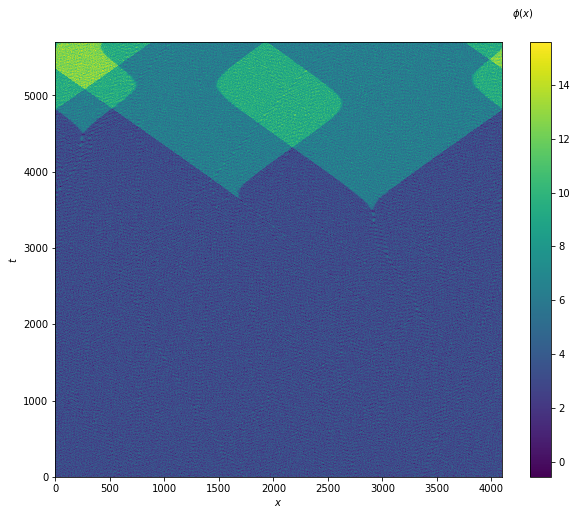

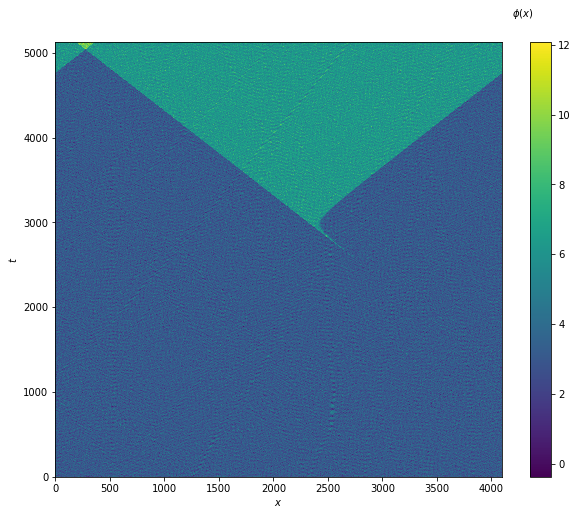

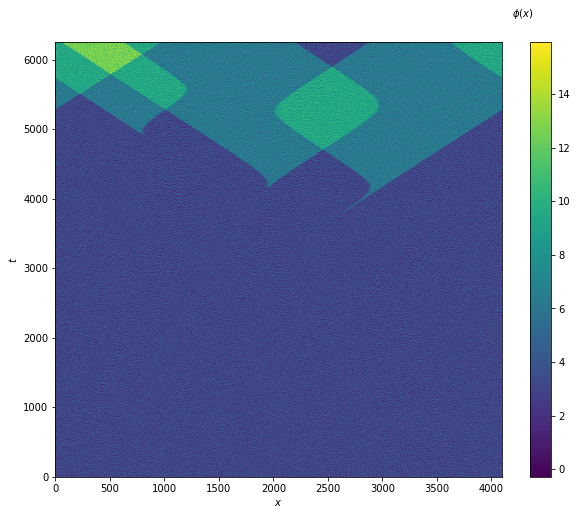

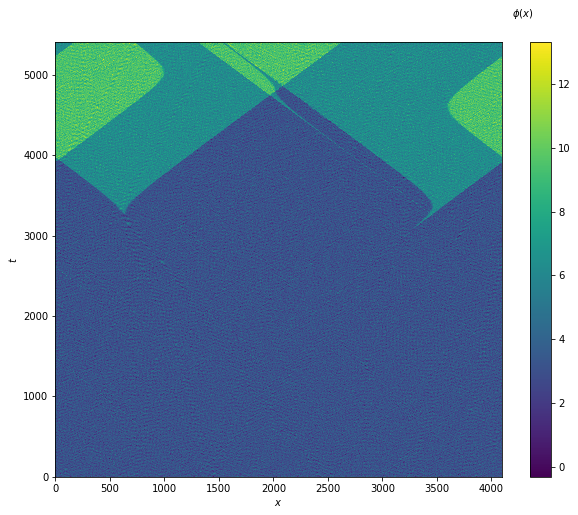

In [8]:
for sim in range(len(all_data))[::]:
    plot_real_space_data(sim, 0)